##### Next update of this network contains:
- normal costs
- proper nodes at one-way bridges, adding bridges to network

### Update
- Simulator class: -> pandas vs geopandas dataframe
- Simulator class: -> pandas twee verschillende dataframes (1 voor x en 1 voor y) -> ves.coor_log vs ves.ds
- Vessel class & Simulator class: -> ipv 1 ves_coor_log list voor elk schip met (x,y) -> 2 coor_logs met 1 voor x en 1 voor y, zodat die in pandas dataframe kunnen worden omgezet in met pd.series en in de colom kunnen worden geplakt.
- Animation function; doet het nog niet helemaal


In [1]:
%load_ext autoreload
%autoreload 2
import random
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from shapely.geometry import Point
from matplotlib import animation
from JSAnimation import IPython_display
%matplotlib inline


In [2]:
#Show with attributes 
graph = gpd.read_file('/Users/JeroenvanderDoes/Dropbox/Studie/Master/Thesis/Onderwerpen/Programs/QGIS/adjusted_complete_graph/edges_water_2.shp')
print(graph.iloc[3]['cost'])
print(graph.head()) # see what attrinutes the edges and nodes from the shapefile contain

6.68129704879482
         cost  source  target  source_aan  target_aan      width  \
0    2.483749     5.0     3.0         3.0         3.0  24.797941   
1  101.826942     5.0   254.0         3.0         3.0  17.942054   
2   11.685232   212.0   217.0         3.0         3.0  10.357033   
3    6.681297   212.0   215.0         3.0         3.0   4.825559   
4    5.221776   215.0   213.0         3.0         3.0   4.365561   

                                            geometry  
0  LINESTRING (120005.5486256767 487357.479141514...  
1  LINESTRING (120005.5486256767 487357.479141514...  
2  LINESTRING (120071.6506543915 487249.971786562...  
3  LINESTRING (120071.6506543915 487249.971786562...  
4  LINESTRING (120074.1340182582 487243.773574981...  


In [3]:
G=nx.read_shp('/Users/JeroenvanderDoes/Dropbox/Studie/Master/Thesis/Onderwerpen/Programs/QGIS/adjusted_complete_graph/edges_water_2.shp', simplify=True) # use simplify is true otherwise chart get shifted
w_G = nx.Graph()

color_map = []
lat_lon_to_index = {}

for i, node in enumerate(G.nodes()): #adds nodes with label 1 till n nodes to the network. 
    w_G.add_node(i, pos= node)
    lat_lon_to_index[node] = i
    color_map.append('b')
    
for edge in G.edges(data=True): # adds edges with attributes to the graph from shapefile according to the order in which the edges are ordered in the shapefile
    w_G.add_edge(lat_lon_to_index[edge[0]], lat_lon_to_index[edge[1]], dis=edge[2]['cost'] )



In [4]:
#nodelist omzetten naar pandas dataframe omdat zodat hij veel makkelijker en sneller de coordinaten van de nodes kan opzoeken
#pandas >>> nx.get_node_attributes kwa snelheid
graph_df = pd.DataFrame.from_dict(nx.get_node_attributes(w_G, 'pos'), orient='index', columns=["lat", "long"]) 

In [5]:
graph_df.head()

,lat,long
0,120005.548626,487357.479142
1,120004.684442,487355.151970
2,120099.941051,487393.298739
3,120071.650654,487249.971787
4,120078.060159,487259.592914


Color_map is for following vessels. nx.draw assigns colors to the order in the graph which they have been added. Therefore, whenever a node is added, so need to add a color "r" to the list. If you later add nodes, then give them anorther color. Whenever nx.draw is active, it will add colors to nodes according to the order in which they have been added.
    

In [6]:
#prints network according to the order in the shapefile
#plt.figure(figsize=(18,18))
#nx.draw(w_G, nx.get_node_attributes(w_G, 'pos'), with_labels=True, node_size=0.5, font_size = 0.5)
#plt.savefig('/Users/JeroenvanderDoes/Downloads/Amsterdam_Canals_8.pdf', format='pdf', rasterized=False)
#plt.show()

In [7]:
distance = ((nx.get_node_attributes(w_G, 'pos')[4091][0]-nx.get_node_attributes(w_G, 'pos')[4013][0])**2+(nx.get_node_attributes(w_G, 'pos')[4091][1]-nx.get_node_attributes(w_G, 'pos')[4013][1])**2)**0.5
print(distance)
# check if this is correct with distance measured in maps and one that is attribute on the egde

1185.9446215938542


### Vessel base class

In [8]:
class Vessel(object):
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.path = self.route(w_G,self.start, self.end)
        self.coor_log = []
        self.vessel_pos = nx.get_node_attributes(w_G, 'pos')[self.path[0]] 
        self.w_G = w_G
        self.to_node_id = 1
        self.move = 3 #aanpassen vooor de tijdsstap, nu  in m/s, en pas aan voor overshoot. 
        self.travel_time = 0
        self.active = True
        self.coor_log_x =[]
        self.coor_log_y=[]
        #self.start_time = simulation.step_count
        
        
        
    def route(self, w_G, start, end):
        return nx.dijkstra_path(w_G, start, end, weight = 'dis')
    
    
    
    def Distance(self, Node1, Node2, Print=False):
        # calculate distance between two points
        distance = ((Node2[0]-Node1[0])**2+(Node2[1]-Node1[1])**2)**0.5

        #if Print == True:
         #   print('distance :', distance)
        return distance
    

    def Angle(self, Node1, Node2, Print=False):
        # calculate angle going from point 1 to point 2 (NB: atan2(y,x))
        angle = math.atan2(Node2[1]-Node1[1],Node2[0]-Node1[0])*(180.0 / math.pi) 
        #if Print == True:
         #   print('angle :', angle)
        return angle
    
    

    def Move(self, Node1, Node2, move, Print=False):#move cannot be replaced by self.move because move may change
        # move towards Node2
        distance = self.Distance(Node1, Node2)
        angle = self.Angle(Node1, Node2)
        new_node = (Node1[0]+math.cos(angle*math.pi/180)*move, Node1[1]+math.sin(angle*math.pi/180)*move)
        #if Print == True:
         #   print('new_node :', new_node)
        return new_node

    
    
    def Move_on_path(self, Print=False):
        # 1. vessel_pos is your boat
        # 2. you need to know the next node in the path
        # 3. calculate the distance between Node1 and the next node
        
        if self.active == True: #stop logging if vessel arrives at destination
            
#             to_node_pos = nx.get_node_attributes(w_G, 'pos')[self.path[self.to_node_id]]
            to_node_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])

            distance_to_next_node = self.Distance(self.vessel_pos, to_node_pos, True)
#             print('distance_to_next_node: ', distance_to_next_node)

            # If move <= distance to next node, make move
            if self.move < distance_to_next_node:
#                     print('move: ', self.move)
                    vessel_pos_new = self.Move(self.vessel_pos, to_node_pos, self.move, True)
                    self.travel_time+=1
                    
            else:
                if self.to_node_id == len(self.path)-1:
                    self.active = False #stop logging if vessel arrives at destination
#                     print('arrived')
                    vessel_pos_new = to_node_pos  
                    self.travel_time +=1
                else:
                    # reposition vessel at next node and calculate remaining move distance
#                     self.vessel_pos = nx.get_node_attributes(w_G, 'pos')[self.path[self.to_node_id]]
                    self.vessel_pos = (graph_df['lat'].loc[self.path[self.to_node_id]], graph_df['long'].loc[self.path[self.to_node_id]])

                    # up the to_node_id with 1 and find new to_node_pos
                    self.to_node_id+=1
                    # calculate distance to next node
#                     print('move: ', self.move)
                    remaining_move = self.move-distance_to_next_node
#                     print('next_move_from_node: ', remaining_move)
                    vessel_pos_new = self.Move(self.vessel_pos, to_node_pos, remaining_move, True)
                    self.travel_time+= 1

            # If move > distance to next node, move to next node and set move to move-distance, try again
            if Print == True:
                print('vessel_pos_new:', vessel_pos_new)
                print('to_node_id :', self.to_node_id)
                print('')

            #self.coor_log.append((self.time, {"pos":vessel_pos_new})) # w_G.add.node()labled as the way networkx labels nodes
            self.coor_log.append(vessel_pos_new) #library for tuple (x,y) coordinate of the vessel
            self.coor_log_x.append(vessel_pos_new[0]) # library for only x coordinates
            self.coor_log_y.append(vessel_pos_new[1])# library for only y coordinates
            self.vessel_pos = vessel_pos_new

            #return vessel_pos_new; for updating the simulator class?

In [9]:
"""tour_path=[]
h =nx.dijkstra_path(w_G, 3806, 96, weight = 'dis')
p =nx.dijkstra_path(w_G, 980, 3806, weight = 'dis')
for i in h:
    tour_path.append(i)
    
for j in p:
    tour_path.append(j)
print(tour_path)
    
"""

"tour_path=[]\nh =nx.dijkstra_path(w_G, 3806, 96, weight = 'dis')\np =nx.dijkstra_path(w_G, 980, 3806, weight = 'dis')\nfor i in h:\n    tour_path.append(i)\n    \nfor j in p:\n    tour_path.append(j)\nprint(tour_path)\n    \n"

In [10]:
class Tour_Vessel(Vessel):
    
     def route(self, w_G, start, end):
            tour_path=[]
            h =nx.dijkstra_path(w_G, 3806, 96, weight = 'dis')
            p =nx.dijkstra_path(w_G, 980, 3806, weight = 'dis')
            for i in h:
                tour_path.append(i)
    
            for j in p:
                tour_path.append(j)
            
            return tour_path
    
    
    

In [11]:
"""
class Pleasure_Craft(Vessel):
    
    def route(self, w_G, start, end):
        return random.sample(nx.all_simple_paths(w_G, start, end, cutoff=None)[0])
        
        
        #nx.all_simple_paths(w_G, start, end, cutoff=None)[0]
"""        
        
        

'\nclass Pleasure_Craft(Vessel):\n    \n    def route(self, w_G, start, end):\n        return random.sample(nx.all_simple_paths(w_G, start, end, cutoff=None)[0])\n        \n        \n        #nx.all_simple_paths(w_G, start, end, cutoff=None)[0]\n'

In [12]:
class Simulation():
    def __init__(self):
        self.stepsize = 10
        self.sim_steps = 100 #int((24*60*60)/self.stepsize)
        self.vessel_count = 8
        self.ves_list = [] #list of active vessel
        self.start_time_list = [] # list for starttimes for vessel for pd.dataframe
        self.distr = self.distr_gen() #chance generator for distribution of vessel of a given day, can be modified to represent different scenarios
        self.step_count = 0
        
        
        
    def run_full_sim(self):
        for i in range(self.sim_steps):
            self.one_sim_step()
            print(i)
        #Create pandas dataframe
#         self.df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))# generate dataframe based on rows: # steps ; colums: # vessels
        self.x_df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))
        self.y_df = pd.DataFrame(np.zeros([self.sim_steps, len(self.ves_list)]))
        
        for i, time, ves in zip(range(len(self.ves_list)), self.start_time_list, self.ves_list):
            #creates dataframe for x coordinates and one for y coordinates based on vessel logs
            ds_x = pd.Series(ves.coor_log_x)
            ds_y =pd.Series(ves.coor_log_y)
            self.x_df[i].iloc[time : time + len(ds_x)] = ds_x.values
            self.y_df[i].iloc[time : time + len(ds_y)] = ds_y.values
            
            #replaces values of 0 to nan for plotting purposes
            self.x_df = self.x_df.replace(0.0, np.nan) 
            self.y_df = self.y_df.replace(0.0, np.nan)

            """only adds coordinates stamps as column in data frame based on timestep in start_time_list; so if a vessel is generated in timestep 20 and
            logs every step and arrives at timestep 30, the coordinates of the timesteps 20 untill 30 are added to the dataframe
            on row 20 untill 30. """
            
        
    def one_sim_step(self):
        for x in range(self.distr[self.step_count]):# generates list of number of boats to be generated for a timestep
            self.ves_list.append(Vessel(random.sample(w_G.nodes, 1)[0],random.sample(w_G.nodes, 1)[0]))
            self.start_time_list.append(self.step_count) # Generate list of starttimes whenever a vessel is generated for pd.DataFrame
            
        for ves in self.ves_list:
            ves.Move_on_path()
        
        self.step_count += 1

        
   
    def distr_gen(self): # voeg boot toe met bepaalde kans 
        threshold = self.vessel_count / float(self.sim_steps)
        count_list = []
    
        # maakt lijst met hoeveel boten er spawnen op elke tijdstap
        for i in range(self.sim_steps):
            counter = 0
            
            while True:
                nummer = random.random()
                if nummer < threshold:
                    counter += 1
                else:
                    break
            count_list.append(counter)
        return count_list
    
    

In [13]:
simulation = Simulation()
simulation.run_full_sim()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [14]:
simulation.x_df

,0,1,2,3,4,5,6,7,8,9,10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,122375.575327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,122373.003644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Animator; werkt nog niet


<IPython.core.display.Javascript object>


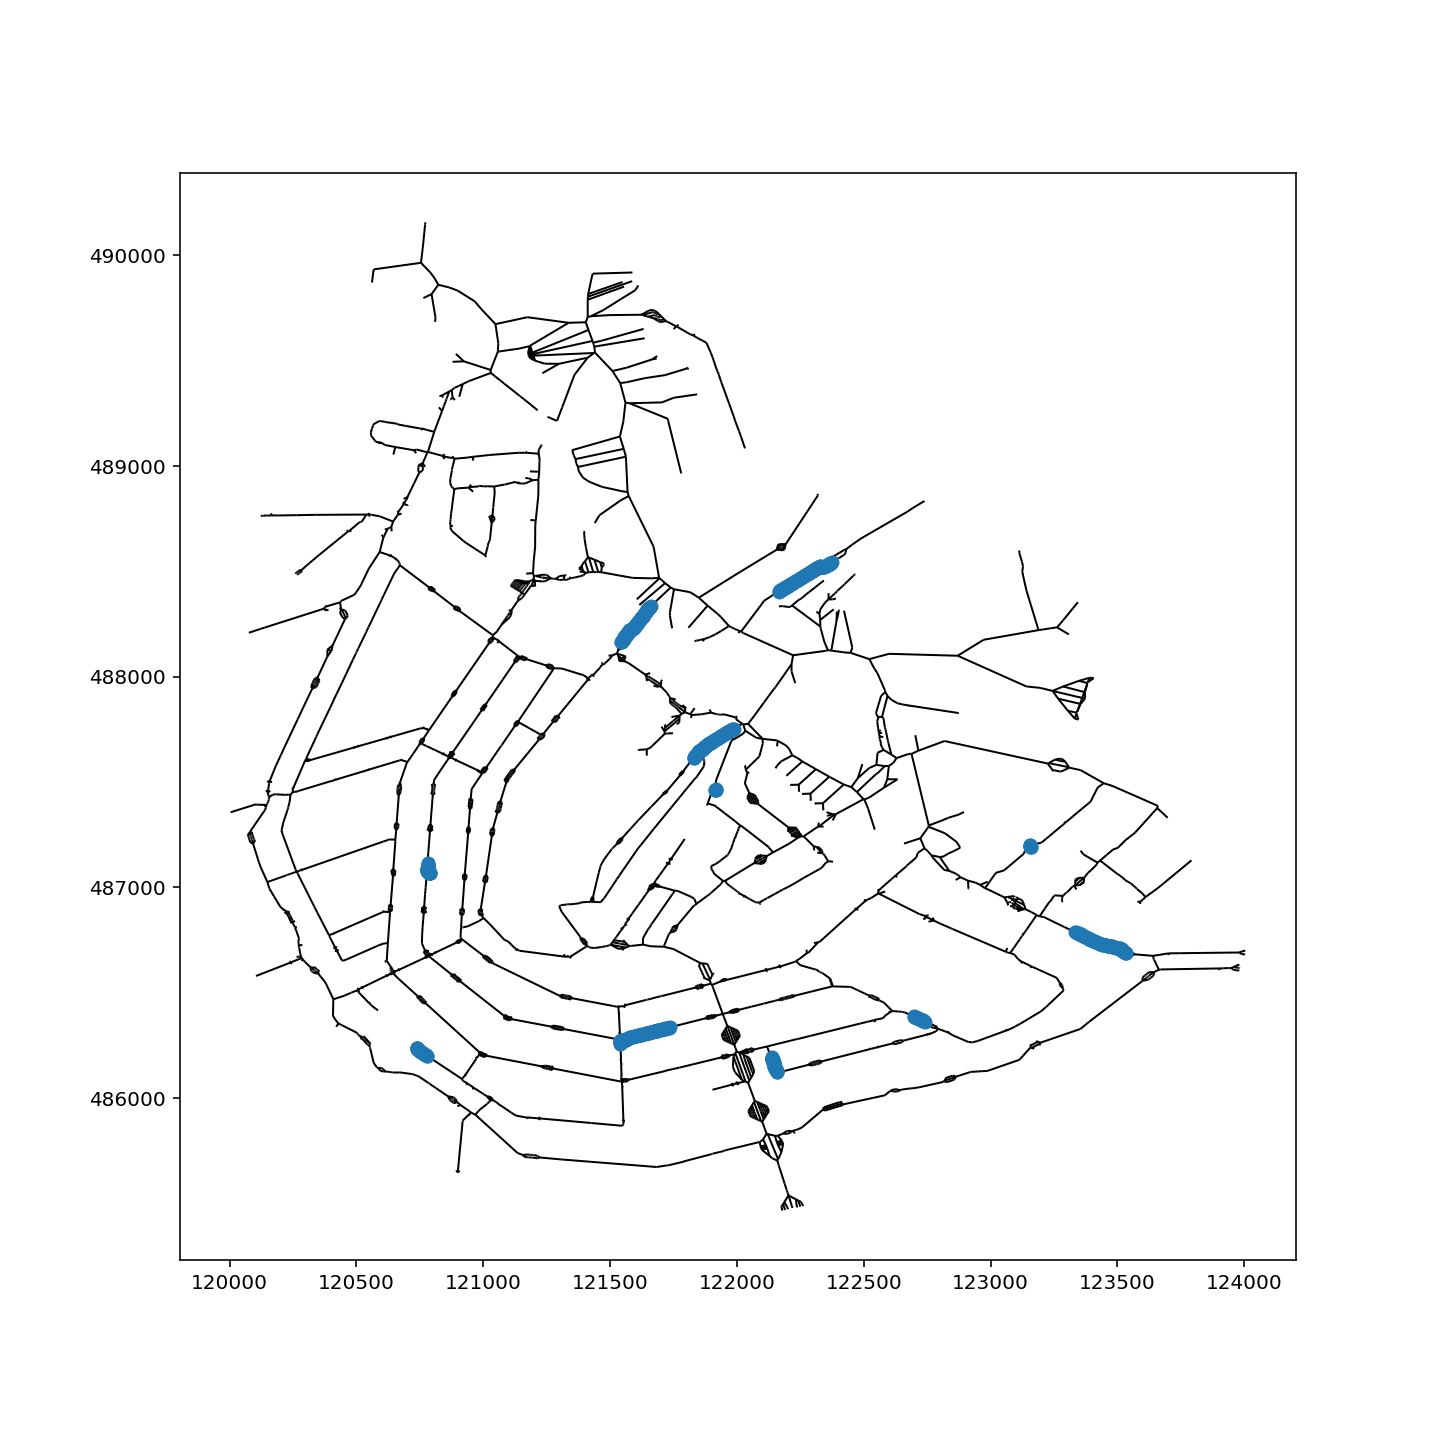

/Users/JeroenvanderDoes/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [19]:
%matplotlib notebook
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(10,10))
#ax = plt.axes()


nx.draw_networkx_edges(w_G,nx.get_node_attributes(w_G, 'pos'))
n_steps = simulation.x_df.index
plt.scatter(simulation.x_df, simulation.y_df)
 
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)

#plt.xlim(120000, 124000)
#plt.ylim(486000, 490000)



#def get_data(data,rownum):
 #   return list(data.loc[rownum])

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)


def init():
    graph, = plt.plot([],[],'o')
    return graph

def animate(i):
    x=df.loc[i, : 0]
    y=df.loc[i, : 0]
    #data = simx.iloc[:int(i+1)] #select data range
    graph.set_data(x,y)
    return graph
    
#a = animate.FuncAnimation(fig, animate, frames=200, repeat=True, blit = True)
#plt.show()

#animation.FuncAnimation(fig, animate, frames=3, init_func = init, repeat=True, blit = True)
plt.show()

In [16]:
print(len(simulation.start_time_list)-1)#check if simulation worked


10


In [17]:
#simulation.gdf.to_csv('output.csv')

In [18]:
list(simx.loc[1])

NameError: name 'simx' is not defined